In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [3]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchdiffeq 
import zuko
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import *
import numpy as np
from zuko.utils import odeint
import pandas as pd

In [4]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP
from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds

2023-07-05 16:12:08.596906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

In [ ]:
class ConcatSquash(nn.Module):

    def __init__(self, *, out_size, key, **kwargs):
        super().__init__(**kwargs)
        self.lin1 = nn.Dense(out_size)
        self.lin2 = nn.Dense(out_size)
        self.lin3 = nn.Dense(out_size, use_bias=False)

    def __call__(self, t, y):
        return self.lin1(y) * jnn.sigmoid(self.lin2(t)) + self.lin3(t)
    
    def create_train_state(
        self, rng: jax.random.PRNGKeyArray, optimizer: optax.OptState, input: Union[int, Tuple[int, ...]], **kwargs: Any
    ) -> NeuralTrainState:
        params = self.init(rng, jnp.ones(input))["params"]
        return TrainState.create(apply_fn=self.apply, params=params, tx=optimizer)


class MLPFFJORD(nn.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, *, data_size, width_size, depth, key, **kwargs):
        super().__init__(**kwargs)
        keys = jrandom.split(key, depth + 1)
        layers = []
        if depth == 0:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=data_size, key=keys[0])
            )
        else:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=width_size, key=keys[0])
            )
            for i in range(depth - 1):
                layers.append(
                    ConcatSquash(
                        in_size=width_size, out_size=width_size, key=keys[i + 1]
                    )
                )
            layers.append(
                ConcatSquash(in_size=width_size, out_size=data_size, key=keys[-1])
            )
        self.layers = layers

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = jnn.tanh(y)
        y = self.layers[-1](t, y)
        return y

In [32]:


class FJJORDSolver:
    def __init__(self,input_dim: int, iterations: int,  neural_net: Optional[MLP]=None, opt: Optional[Any] = None, noise_dim: int =0) -> None:
        self.optimizer = optax.adamw(learning_rate=1e-4, weight_decay=1e-10) if opt is None else opt
        self.rng = jax.random.PRNGKey(0)
        self.input_dim = input_dim
        self.iterations = iterations
        self.state_eta: Optional[TrainState] = None
        if neural_net is None:
            self.neural_net = MLP(
                dim_hidden=[128, 128, 128, 128], is_potential=False, noise_dim=noise_dim, act_fn=nn.relu
            )
        else:
            self.neural_net = neural_net

        self.setup()

    def __call__(self, x, y, batch_size_source, batch_size_target) -> Any:
        x_loader = iter(tf.data.Dataset.from_tensor_slices(x).repeat().shuffle(buffer_size=10_000).batch(batch_size_source))
        y_loader = iter(tf.data.Dataset.from_tensor_slices(y).repeat().shuffle(buffer_size=10_000).batch(batch_size_target))
        
        batch: Dict[str, jnp.ndarray] = {}
        for step in tqdm(range(self.iterations)):
            batch["source"], batch["target"] = tfds.as_numpy(next(x_loader)), tfds.as_numpy(next(y_loader))
            self.state_neural_net, loss = self.step_fn(self.state_neural_net, batch)

    def setup(self):
        self.state_neural_net = self.neural_net.create_train_state(self.rng, self.optimizer, self.input_dim)
        self.step_fn = self._get_step_fn()

    def _get_step_fn(self)-> Callable:
        def loss_fn(params_mlp: jnp.ndarray, apply_fn_mlp: Callable, source: jnp.ndarray, target:jnp.ndarray):
            def solve(source):
                solution = diffrax.diffeqsolve(
                    #diffrax.ODETerm(lambda t,y, args: apply_fn_mlp({"params": params_mlp}, t, y, args)),
                    diffrax.ODETerm(lambda t,y, args: apply_fn_mlp({"params": params_mlp}, y)),
                    diffrax.Tsit5(),
                    t0=0,
                    t1=1,
                    dt0=1,
                    y0=source,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    #saveat=diffrax.SaveAt(ts=ts),
                    )
                return solution.ys
            #target_pred = jax.vmap(solve, in_axes=(None, 0))(source)
            target_pred = jax.vmap(solve)(source)
            return jnp.mean((target_pred - target) ** 2)
        
        def step_fn(state_neural_net: TrainState, batch: Dict[str, jnp.ndarray]):
            grad_fn = jax.value_and_grad(loss_fn, argnums=0, has_aux=False)
            val, grads = grad_fn(state_neural_net.params, state_neural_net.apply_fn, batch["source"], batch["target"])
            return state_neural_net.apply_gradients(grads=grads), val

        return step_fn
    
    

In [41]:
sl = NeuralODESolver(1, 500)

In [42]:
sl(source, target, 64, 64)

 19%|█▉        | 96/500 [11:35<48:45,  7.24s/it]  


KeyboardInterrupt: 

In [43]:
predicted_target = sl.state_neural_net.apply_fn({"params": sl.state_neural_net.params}, target)

<Axes: ylabel='Density'>

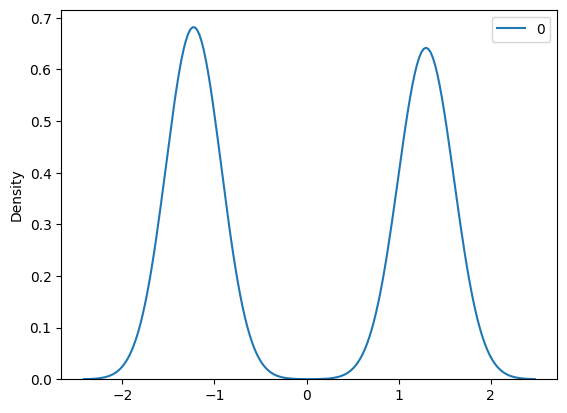

In [44]:
import seaborn as sns
sns.kdeplot(predicted_target)

<Axes: ylabel='Density'>

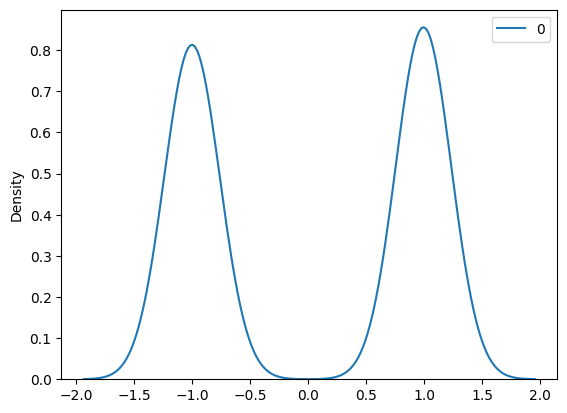

In [45]:
sns.kdeplot(target)